참고 : https://github.com/yellowjs0304/3-min-pytorch_study/blob/master/09-%EA%B2%BD%EC%9F%81%ED%95%98%EB%A9%B0_%ED%95%99%EC%8A%B5%ED%95%98%EB%8A%94_GAN/gan.ipynb

In [9]:
from importlib import import_module #import muodule 확인
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [10]:
#에포크, 배치사이즈 등의 학습 하이퍼파라미터 설정
EPOCHS = 50
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else "cpu")
print("Using Device : ", DEVICE)

Using Device :  cuda


#FashionMNIST 데이터셋 링크 : https://www.tensorflow.org/datasets/catalog/fashion_mnist?hl=ko

In [13]:
#데이터셋 로드 
trainset = datasets.FashionMNIST(
    './.data',
    train = True,
    download= True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [15]:
# 생성자는 64차원의 랜덤 텐서를 input으로 받아 행렬곱(linear), 활성화함수(ReLU, Tanh) 연산을 실행
# 생성자의 결과값은 784차원, FashinMNIST에 있는 이미지와 같은 텐서로 출력됨
# 생성자 G
G = nn.Sequential(
    nn.Linear(64,256), #64->256차원
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,784),
    nn.Tanh()
)

In [16]:
# 판별자는 784차원의 텐서를 입력받음, 
#판별자에서도 행렬곱과 활성화 함수를 실행하나
#생성자와 달리 판별자는 입력받은 텐서(G의 결과값)에 대해 진짜인지 구분하는 예측값(기존 1차원)을 출력
D = nn.Sequential(
    nn.Linear(784, 256), #784->256차원
    nn.LeakyReLU(0.2),
    nn.Linear(256,256),
    nn.LeakyReLU(0,2),
    nn.Linear(256,1),
    nn.Sigmoid() #sigmoide() 함수를 거쳐서 가짜(0)~진짜(1) 사이의 값을 반환 
)

In [17]:
#생성자와 판별자 학습에 쓸 목적 함수와 최적 알고리즘도 정의
# 모델의 가중치를 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

#목적함수 : 이진 크로스 엔트로피 함수
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(), lr = 0.0002)

모델 학습을 위한 세팅 완료, 이제는 GAN을 학습시키는 Loop 만들어보자

In [21]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)# [1,1,1...]
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)# [0.0,0...]
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images) # 진짜 이미지를 discriminator의 입력으로 제공
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z) #G의 입력으로 랜덤 텐서 제공, G가 fake image 생성
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)# 가짜 이미지를 discriminator의 입력으로 제공
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 Discriminator의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        #------ Discriminator 학습 ------#
        # 역전파 알고리즘으로 Discriminator의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()# Discriminator 학습
        
        # 생성자가 판별자를 속였는지에 대한 오차(Generator의 loss)를 계산
        fake_images = G(z)
        outputs = D(fake_images) #한번 학습한 D가 fake image를 
        g_loss = criterion(outputs, real_labels)

         #------ Generator 학습 ------#
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/50], d_loss: 0.0887, g_loss: 3.6289, D(x): 0.97, D(G(z)): 0.06
Epoch [1/50], d_loss: 0.0370, g_loss: 4.0740, D(x): 1.00, D(G(z)): 0.03
Epoch [2/50], d_loss: 0.0521, g_loss: 5.6714, D(x): 0.98, D(G(z)): 0.02
Epoch [3/50], d_loss: 0.1743, g_loss: 4.3311, D(x): 0.95, D(G(z)): 0.03
Epoch [4/50], d_loss: 0.2142, g_loss: 5.2676, D(x): 0.91, D(G(z)): 0.04
Epoch [5/50], d_loss: 0.2147, g_loss: 4.5884, D(x): 0.97, D(G(z)): 0.14
Epoch [6/50], d_loss: 0.1341, g_loss: 5.2612, D(x): 0.96, D(G(z)): 0.04
Epoch [7/50], d_loss: 0.0626, g_loss: 5.9334, D(x): 0.97, D(G(z)): 0.03
Epoch [8/50], d_loss: 0.2526, g_loss: 3.0766, D(x): 0.92, D(G(z)): 0.06
Epoch [9/50], d_loss: 0.1694, g_loss: 4.4784, D(x): 0.96, D(G(z)): 0.06
Epoch [10/50], d_loss: 0.1796, g_loss: 3.9934, D(x): 0.95, D(G(z)): 0.08
Epoch [11/50], d_loss: 0.4043, g_loss: 3.9648, D(x): 0.87, D(G(z)): 0.08
Epoch [12/50], d_loss: 0.1931, g_loss: 4.1042, D(x): 0.97, D(G(z)): 0.11
Epoch [13/50], d_loss: 0.2870, g_loss: 5.4025, D(x): 0.89, D(

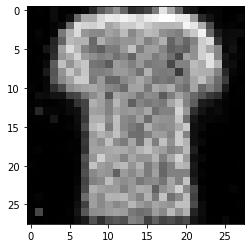

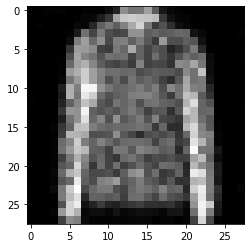

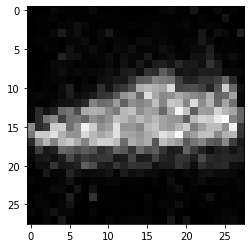

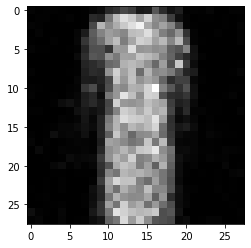

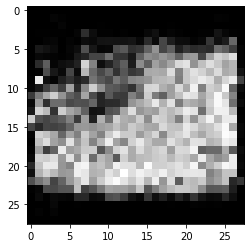

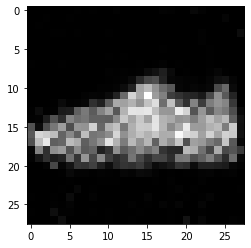

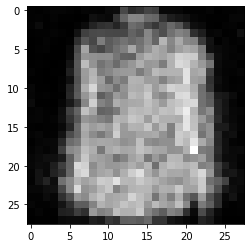

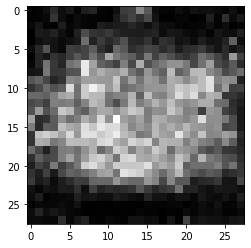

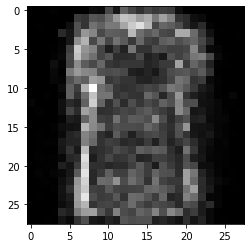

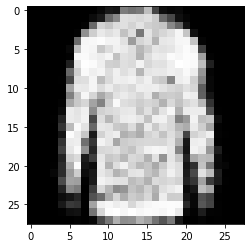

In [23]:
#학습이 끝난 생성자가 만든 결과물 확인
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()